In [ ]:
from google.colab import files
import io
import pandas as pd


data = files.upload()


filename = next(iter(data))
file_content = data[filename]


data = pd.read_csv(io.BytesIO(file_content))


Saving pre_model_data.csv to pre_model_data.csv


In [ ]:

missing_data = data.isnull().sum()


data_types = data.dtypes

missing_data, data_types


(player_id                   0
 Year                        0
 matches_appearances         0
 yellow_permatch             0
 red_permatch                0
 goals_permatch              0
 assists_permatch            0
 min_permatch                0
 name                        0
 country_of_birth          479
 country_of_citizenship    424
 city_of_birth              55
 Year_birth                  0
 position                    0
 foot                        6
 height_in_cm                6
 mat                         0
 win_percentage              0
 major_league                0
 Age                         0
 market_value_in_eur         0
 value_increase              0
 matches                     0
 club_changed                0
 type_ratio                  0
 ever_captain                0
 dtype: int64,
 player_id                   int64
 Year                        int64
 matches_appearances         int64
 yellow_permatch           float64
 red_permatch              float64
 goa

In [ ]:

data.fillna({'country_of_birth': 'Unknown', 'country_of_citizenship': 'Unknown', 'city_of_birth': 'Unknown'}, inplace=True)


data_encoded = pd.get_dummies(data, columns=['name', 'country_of_birth', 'country_of_citizenship', 'city_of_birth', 'position', 'foot'])


data_encoded.shape, data_encoded.columns


((11587, 2700),
 Index(['player_id', 'Year', 'matches_appearances', 'yellow_permatch',
        'red_permatch', 'goals_permatch', 'assists_permatch', 'min_permatch',
        'Year_birth', 'height_in_cm',
        ...
        'city_of_birth_Żnin', 'city_of_birth_Žiar nad Hronom',
        'city_of_birth_Žilina', 'position_Attack', 'position_Defender',
        'position_Goalkeeper', 'position_Midfield', 'foot_both', 'foot_left',
        'foot_right'],
       dtype='object', length=2700))

In [ ]:

data_encoded.sort_values(by=['player_id', 'Year'], inplace=True)


data_encoded['market_value_change'] = data_encoded.groupby('player_id')['market_value_in_eur'].diff()

data_encoded['market_value_trend'] = pd.cut(data_encoded['market_value_change'],
                                            bins=[-float('inf'), -1, 1, float('inf')],
                                            labels=['Fall', 'Same', 'Rise'])

data_encoded.dropna(subset=['market_value_trend'], inplace=True)

data_encoded['market_value_trend'].value_counts()


market_value_trend
Fall    5249
Rise    3543
Same    1332
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = data_encoded.drop(['player_id', 'Year', 'market_value_in_eur', 'market_value_change', 'market_value_trend'], axis=1)
y = data_encoded['market_value_trend']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8099, 2697), (2025, 2697), (8099,), (2025,))

In [ ]:
from sklearn.metrics import classification_report

data_encoded_clean = data_encoded.dropna()

X_clean = data_encoded_clean.drop(['player_id', 'Year', 'market_value_in_eur', 'market_value_change', 'market_value_trend'], axis=1)
y_clean = data_encoded_clean['market_value_trend']

X_clean_scaled = scaler.fit_transform(X_clean)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean_scaled, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

from sklearn.svm import SVC

svm_model_clean = SVC(kernel='linear', probability=True, random_state=42)
svm_model_clean.fit(X_train_clean, y_train_clean)

y_pred_clean = svm_model_clean.predict(X_test_clean)
report_clean = classification_report(y_test_clean, y_pred_clean)

print(report_clean)


              precision    recall  f1-score   support

        Fall       0.82      0.89      0.85      1050
        Rise       1.00      1.00      1.00       708
        Same       0.33      0.22      0.26       266

    accuracy                           0.84      2024
   macro avg       0.72      0.70      0.70      2024
weighted avg       0.82      0.84      0.83      2024



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_clean = classification_report(y_test_clean, y_pred_clean, output_dict=True)
df_report = pd.DataFrame(report_clean).transpose()

print(df_report)


              precision    recall  f1-score      support
Fall           0.817704  0.888571  0.851666  1050.000000
Rise           1.000000  1.000000  1.000000   708.000000
Same           0.331429  0.218045  0.263039   266.000000
accuracy       0.839427  0.839427  0.839427     0.839427
macro avg      0.716377  0.702206  0.704901  2024.000000
weighted avg   0.817564  0.839427  0.826194  2024.000000


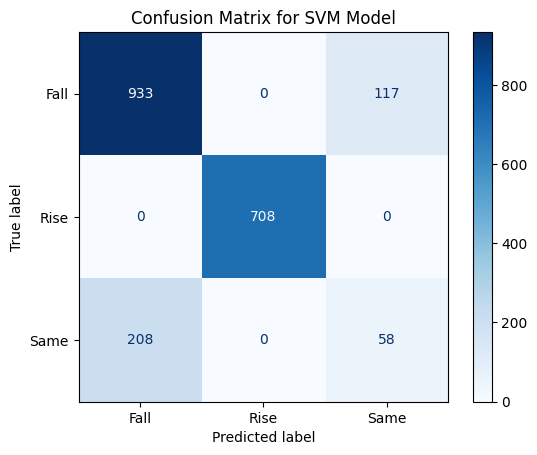

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_clean, y_pred_clean, labels=svm_model_clean.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model_clean.classes_)

disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SVM Model')
plt.show()


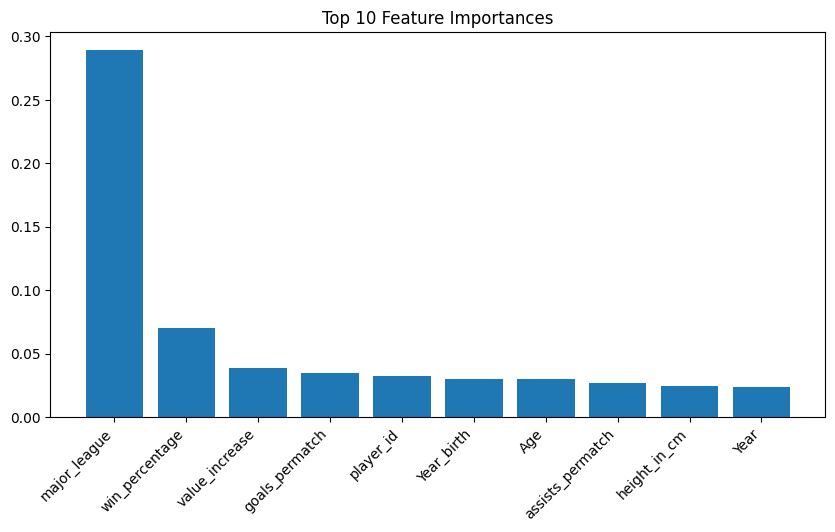

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train_imputed, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
names = [data_encoded.columns[i] for i in indices[:10]]

plt.figure(figsize=(10, 5))
plt.title('Top 10 Feature Importances')
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), names, rotation=45, ha='right')
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/SVM_football.keras')

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model(/content/drive/MyDrive/Colab Notebooks/SVM_football.keras)